# Real data experiments

We perform real data experiments on the Imagenet and MSCOCO datasets, for controlling risk metrics of various classifiers. These experiments have identical setup to the experiments in [Distribution-Free, Risk-Controlling Prediction Sets](https://arxiv.org/abs/2101.02703).

## Imagenet

Imagenet examples consist of an image $x \in \mathcal{X}$ that is paired with a single correct class $y \in \mathcal{Y}$.

Our loss is defined as follows for a label set $S$, and the corresponding true label $y$ is as follows:

$$ L(y, S) := L_y \mathbf{1}_{\left\{y \not\in S\right\}},$$

where $L_y \in \mathbb{R}^+$ denotes a user chosen penalty weight specifically for class $y$.

We can use a probabilistic classifier $\mathbf{p}: \mathcal{X} \mapsto \Delta^{|\mathcal{Y}|}$ to produce a probability distribution $\mathbf{p}(x)$ for each image $x$. Then, we can define the corresponding label set as follows:
$$S(x) := \left\{y \in \mathcal{Y}: \mathbf{p}(x)_y \geq \beta \right\},$$
where $\beta \in [0, 1]$ is the cutoff threshold for which labels to include in the label set.

We directly work with $\mathbf{p}(x)$ generated using a ResNet512 classifier trained on Imagenet.

In [1]:
def load_data(data_dir):
    import load_data
    return load_data.load_imagenet_torch_preds(data_dir)

In [2]:
data_dir = 'data/imagenet_no_T'
scores, labels = load_data(data_dir)
scores.shape, labels.shape

((50000, 1000), (50000,))

[0.   0.25 0.5  0.75 1.  ]


Compute average risk:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ziyux/research/msr/Risk.py:75: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  res = self._compute_loss(torch.Tensor(P), torch.Tensor([Y]).reshape(-1).int(), betas).numpy()


[0.21685785, 0.21305752, 0.18489791, 0.124759324, 6e-05]


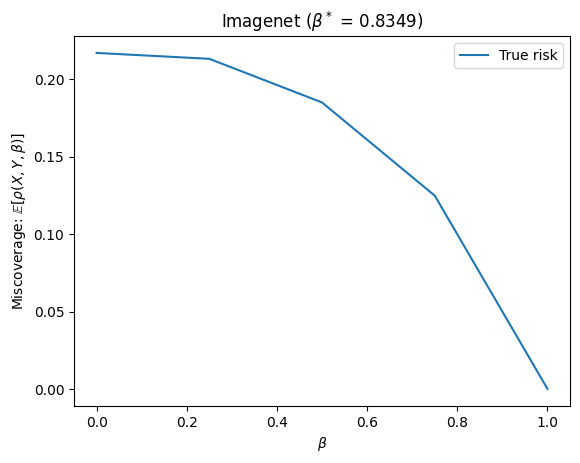

In [3]:
def predicted_risk(P, w, beta):
    import torch
    
    P, w = torch.Tensor(P), torch.Tensor(w)
    w_P = P * w.reshape(1, -1)
    w_P_sq = torch.square(P) * w.reshape(1, -1)
    sort_arr, idx_arr = torch.sort(w_P, descending=True, dim=-1, stable=True)


    sums_arr = torch.cumsum(sort_arr, dim=-1)
    top_idx = torch.argmax((sums_arr >= beta).int(), dim=-1)
    # if all sums are below beta, set to last possible index (i.e., include all labels)
    sum_small_idxs = torch.all(sums_arr < beta, dim=-1)
    top_idx[sum_small_idxs] = w.shape[0] - 1
        
    exc_sums = []
    for i in range(P.shape[0]):
        if top_idx[i] == w.shape[0] - 1:
            exc_sums.append(0)
        else:
            exc_idxs = idx_arr[i, (top_idx[i] + 1):]
            exc_sums.append(((w[exc_idxs] ** 2) * P[i, :][exc_idxs]).sum())
    return torch.Tensor(exc_sums).numpy()


def plot_imagenet_true_rho(scores, labels):
    import matplotlib.pyplot as plt
    import numpy as np
    from tqdm.notebook import tqdm
    import scipy
    
    from Risk import TopBetaCoverage
    
    
    rho = TopBetaCoverage()
    
    betas = np.linspace(0.0, 1., 5)
    print(betas)
    # predicted_risks = [np.mean(predicted_risk(scores, np.ones(1000), beta)) for beta in betas]
    # risks = [np.mean([rho(((scores[i].reshape(1, -1), None), [labels[i]]), beta) for i in range(len(scores))]) for beta in tqdm(betas, 'Compute average risk')]
    risks = [np.mean(rho(((scores, None), labels), beta)) for beta in tqdm(betas, 'Compute average risk')]
    
    print(risks)
    # print(other_risks)
    
    theta = 0.1
    def func(beta):
        return np.mean(rho(((scores, None), labels), beta)) - theta
    res = scipy.optimize.root_scalar(func, method='brentq', rtol=1e-4, bracket=(0, 1))
    assert res.converged, "Didn't converge"
    
    fig, ax = plt.figure(), plt.gca()
    ax.set_title(f"Imagenet ($\\beta^*$ = {res.root:.4f})")
    
    ax.plot(betas, risks, label='True risk'), ax.set_xlabel('$\\beta$'), ax.set_ylabel('Miscoverage: $\\mathbb{E}[\\rho(X, Y, \\beta)]$')
    # ax.plot(betas, predicted_risks, label='Predicted risk')
    ax.legend()
    
    # fig, ax = plt.figure(), plt.gca()
    # ax.hist([np.sum(row[row > 0] * np.log(1 / row[row > 0])) for row in scores]), ax.set_xlabel('$H(\mathbf{p}(X))$'), ax.set_ylabel('Frequency')
    # ax.set_title('Imagenet Entropies')
plot_imagenet_true_rho(scores, labels)

In [4]:
def digitize(p, knots):
    import torch
    rv = torch.zeros(len(knots))
    if p >= knots[-1]:
        rv[-1] = 1.
    else:
        z = torch.bucketize(p, knots)
        vlow, vhigh = knots[z-1], knots[z]
        frac = (p - vlow) / (vhigh - vlow)
        rv[z - 1], rv[z] = 1 - frac, frac
    return rv



def featurize(P, w, beta, knots_type='uneven'):
    import torch
    
    if knots_type == 'even':
        beta_knots = torch.linspace(0, 1, 5)
        est_loss_knots = torch.linspace(0, 1, 10)
    else:
        beta_knots = torch.cat([torch.zeros(1), torch.linspace(0.9, 1, 4)])
        est_loss_knots = torch.linspace(0, 1, 10)
    
    tbc = TopBetaCoverage(torch_w=w)
    w_P_sq = P * (w ** 2).reshape(1, -1)
    
    exc_sums = (w_P_sq * (~(tbc.beta_coverage_set(P, torch.Tensor([beta])))).int()).sum(dim=-1)
    beta_vec = torch.cat([digitize(beta, beta_knots), torch.ones(1)])
    scale_factor = 1 if torch.all(beta_knots > beta) else (1 - beta_knots[torch.argmin((beta_knots <= beta).int()) - 1])
    # print(est_loss_knots * scale_factor)
    # print(exc_sums)
    #print(beta, beta_knots, scale_factor, beta_knots <= beta)
    
    rvs = []
    for i in range(len(exc_sums)):
        exc_sum_vec = digitize(exc_sums[i], est_loss_knots * scale_factor)
        rvs.append(torch.outer(beta_vec, exc_sum_vec).reshape(1, -1))
    res = torch.concatenate(rvs)
    return res

Running samples:   0%|          | 0/5000 [00:00<?, ?it/s]

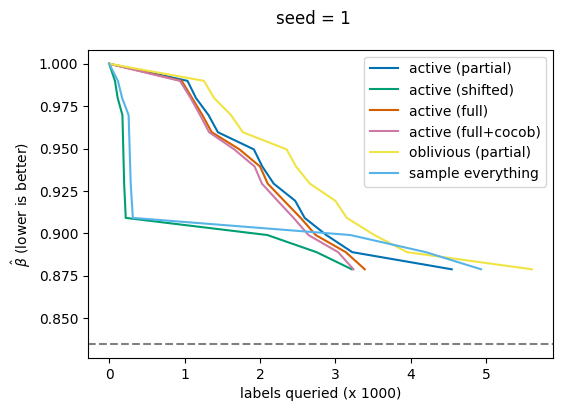

In [6]:
%matplotlib inline
def test_once(seed, dipslay_step=1000):
    from itertools import product
    from Cocob import CocobBackprop
    from IwUpperMartingale import FullIwUpperMartingale, PartialIwUpperMartingale, FullyObservedUpperMartingale, ShiftedIwUpperMartingale, BaseMartingale
    from OnlineMinimax import OnlineMinimax, WindowedBeTheLeader
    from LogisticRegression import MultilabelRegressor
    from Risk import TopBetaCoverage
    from Features import featurize
    import numpy as np
    import torch
    from tqdm.notebook import tqdm
    import multiprocess as mp
    from Player import Player


    
        
            
    if True:
        torch.manual_seed(seed)
        np.set_printoptions(2, floatmode='fixed')

        wc_rho = TopBetaCoverage()
        rho = lambda x, beta: wc_rho(x, beta, is_torch=True)
        theta = 0.1
        q_min = 0.1
        target_rate = 0.3
        
        
        
        # feature_ct = (len(beta_knots) + 1) * len(est_loss_knots)
        feature_ct = 60
        def makeMinimax(policy, lr, q_min, target_rate, iwmart, optimizer='adam'):
            from Player import LabellingPolicyPrimalPlayer
            if optimizer == 'adam':
                opt = torch.optim.Adam(policy.parameters(), lr=lr)
                sched = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda t:1) # (1+t/1000)**(-0.5))
            else:
                opt = CocobBackprop(policy.parameters())
                sched = None
            primal_player = LabellingPolicyPrimalPlayer(policy=policy, 
                                                        q_min=q_min,
                                                        target_rate=target_rate,
                                                        theta=theta,
                                                        rho=rho,
                                                        opt=opt,
                                                        sched=sched,
                                                        iwmart=iwmart)
            # anything bigger than (1 - Log[2]) should be good enough for max_dual
            dual_player = WindowedBeTheLeader(max_dual=1 - np.log(2), window_size=256)
            return OnlineMinimax(primal_player=primal_player, dual_player=dual_player)        
        
        base_rate = (target_rate - q_min) / (1 - q_min)
        
        partial_minimax = makeMinimax(policy=MultilabelRegressor(in_features=feature_ct, out_classes=1, bias=True, base_rate=base_rate),
                                                lr=5e-3,
                                                q_min=q_min, 
                                                target_rate=target_rate,
                                                iwmart=PartialIwUpperMartingale(rho=rho, theta=theta, q_min=q_min, n_betas=100, alpha=0.05),
                                               )
        
        shifted_minimax = makeMinimax(policy=MultilabelRegressor(in_features=feature_ct, out_classes=1, bias=True, base_rate=base_rate),
                                         lr=5e-3,
                                         q_min=q_min, 
                                         target_rate=target_rate,
                                         iwmart=ShiftedIwUpperMartingale(rho=rho, theta=theta, n_betas=100, alpha=0.05),
                                        )
        
        full_cocob_minimax = makeMinimax(policy=MultilabelRegressor(in_features=feature_ct, out_classes=1, bias=True, base_rate=base_rate),
                                      lr=5e-3,
                                      q_min=q_min, 
                                      target_rate=target_rate,
                                      iwmart=FullIwUpperMartingale(rho=rho, theta=theta, q_min=q_min, n_betas=100, alpha=0.05),
                                        optimizer='cocob'
                                      )
        
        full_minimax = makeMinimax(policy=MultilabelRegressor(in_features=feature_ct, out_classes=1, bias=True, base_rate=base_rate),
                                      lr=5e-3,
                                      q_min=q_min, 
                                      target_rate=target_rate,
                                      iwmart=FullIwUpperMartingale(rho=rho, theta=theta, q_min=q_min, n_betas=100, alpha=0.05),
                                      )
        const_minimax = makeMinimax(policy=MultilabelRegressor(in_features=feature_ct, out_classes=1, bias=False), 
                                       lr=0,
                                       q_min=q_min, 
                                       target_rate=target_rate,
                                       iwmart=PartialIwUpperMartingale(rho=rho, theta=theta, q_min=q_min, n_betas=100, alpha=0.05),
                                      )
        fobv_minimax = OnlineMinimax(primal_player=Player(
                                      iwmart=FullyObservedUpperMartingale(rho=rho, theta=theta, n_betas=100, alpha=0.05)),
                                      dual_player=WindowedBeTheLeader(max_dual=1 - np.log(2), window_size=256))
        
        
        
    randperm = torch.randperm(len(scores))
    rand_scores, rand_labels = torch.Tensor(scores[randperm]), torch.Tensor(labels[randperm]).int()
    
    minimaxes = [partial_minimax, shifted_minimax, full_cocob_minimax, full_minimax, const_minimax, fobv_minimax]
    sumlses, betases = [[0] for _ in range(len(minimaxes))], [[minimax._primal_player._iwmart.curbeta[0]] for minimax in minimaxes]
    names = ['active (partial)', 'active (shifted)', 'active (full)', 'active (full+cocob)', 'oblivious (partial)', 'sample everything']
    for n in tqdm(range(5000), desc="Running samples"):
    
        p, y = rand_scores[n], rand_labels[n]
        
        for minimax, sumls, betas in list(zip(minimaxes, sumlses, betases)):
            curbeta = minimax._primal_player._iwmart.curbeta[0]
            x = featurize(p.reshape(1, -1), torch.ones(1000), curbeta).reshape(1, -1)
            in_data = ((p.reshape(1, -1), x), y.reshape(1, -1))
            minimax.addobs(in_data)
            
            if curbeta < betas[-1]:
                sumls.append(minimax._primal_player._suml)
                betas.append(curbeta)

    with torch.no_grad():
        import matplotlib.pyplot as plt 
        with plt.style.context("seaborn-colorblind"):
            fig, ax = plt.figure(figsize=(6, 4)), plt.gca()
            fig.suptitle(f'seed = {seed}')
            
            step_scale = 1000
            for name, betas, sumls in zip(names, betases, sumlses):
                ax.plot(np.array(sumls)/step_scale, betas, label=name)
            ax.set_xlabel(f'labels queried (x {step_scale})')
            ax.set_ylabel('$\\hat{\\beta}$ (lower is better)')
            ax.axhline(.8349, linestyle='dashed', color='gray')
            ax.legend()

    return minimaxes

    
def test():
    for seed in range(1, 2):
        res = test_once(seed=seed)
    return res
minimaxes_2 = test()

[0.01943274959921837, 0.060477204620838165, 0.0809408500790596, 0.10436680912971497, 0.12226640433073044, 0.1205466091632843, 0.14462243020534515, 0.15671326220035553, 0.15637584030628204, 0.1427217274904251]


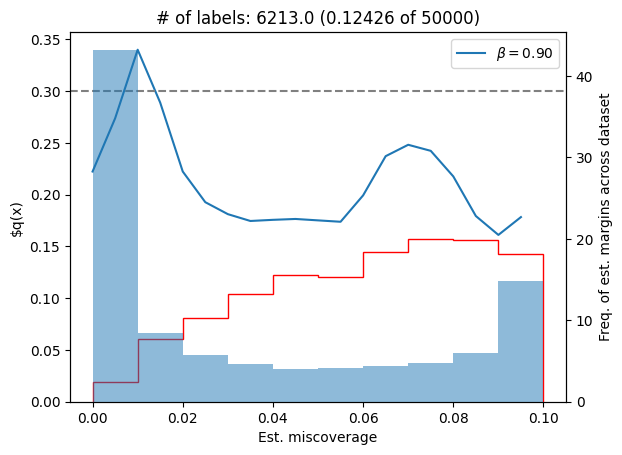

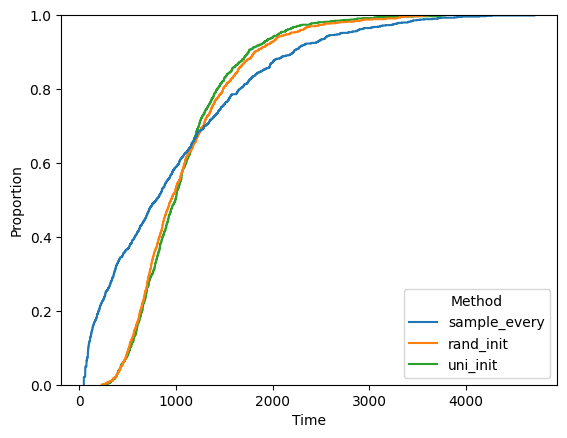

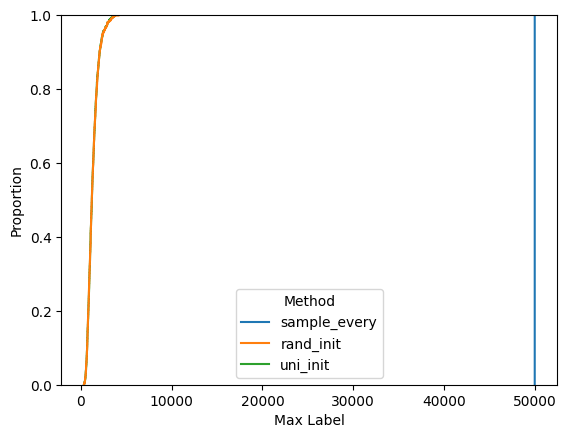

In [7]:
def make_probe_data(test_beta, weights, margin, featurize):
    import torch
    Xs = []
    ps = []
    temp_weights = torch.ones(1000)
    for i in range(len(margin)):
        temp_p = torch.zeros(1000)
        temp_p[0] = test_beta + (1 - margin[i])
        temp_p[1] = margin[i]
        ps.append(temp_p.reshape(1, -1))
        Xs.append(featurize(temp_p.reshape(1, -1), weights, test_beta).reshape(1, -1))

    X = torch.concatenate(Xs)
    p = torch.concatenate(ps)
    return p, X

def probe(minimax, featurize, scores, labels, budget):
    import numpy as np
    import matplotlib.pyplot as plt
    import torch
    from Risk import TopBetaCoverage
    
    betas = np.arange(0.9, 1, 0.01)
    margins = np.arange(0.00, 0.11, 0.005) 
    probe_datas = [make_probe_data(beta, torch.ones(1000), margins, featurize) for beta in betas]
    results = []
    
    for probe_data in probe_datas:
        (Q, _), cons = minimax._primal_player.predict((probe_data, None))
        results.append(Q.detach().numpy())
    
    q_vals = np.array(results)
    tbc = TopBetaCoverage()
    cov_set = tbc.beta_coverage_set(torch.Tensor(scores), 0.9)
    miscovers = ~(cov_set[np.arange(cov_set.shape[0]), labels])
    est_miscovers = (torch.Tensor(scores) * (~(cov_set)).int()).sum(dim=-1).detach().numpy()
    
    fig, ax = plt.figure(), plt.gca()
    #for i in range(0, len(betas), 1):
    i = 0
    beta, q_val = betas[i], q_vals[i]
    max_margin = 1 - beta
    mask = margins <= max_margin
    ax.plot(margins[mask], q_val[mask], label=f"$\\beta={beta:.2f}$")
    twin_ax = ax.twinx()
    _, bins, _ = twin_ax.hist(est_miscovers, alpha=0.5, density=True)
    
    bin_indices = np.digitize(est_miscovers, bins)
    
    bin_miscovers = []
    for i in range(1, len(bins)):
        bin_miscovers.append(torch.mean(miscovers[bin_indices == i].float()).detach().item())
    print(bin_miscovers)
    ax.stairs(bin_miscovers, bins, color='red')
    
    twin_ax.set_ylabel('Freq. of est. margins across dataset')
    ax.axhline(budget, linestyle='dashed', color='gray')
    ax.set_xlabel('Est. miscoverage'), ax.set_ylabel('$q(x)')
    ax.set_title(f'# of labels: {minimax._primal_player._suml} ({minimax._primal_player._suml / len(scores)} of {len(scores)})')
    ax.legend()
from Features import featurize
probe(minimaxes_2[0], featurize, scores, labels, 0.3)
# probe(minimaxes[1], featurize, scores, 0.3)            


def load_single_beta_results():
    import dill
    import pandas as pd
    import IwUpperMartingale
    from IwUpperMartingale import DummyMartingale     
    data_dir = 'results/single_beta=0.9_trials=1000'
    with open(f'{data_dir}/result_dump.pkl', 'rb') as in_f:
        datas = dill.load(in_f)
    data_df = pd.read_csv(f'{data_dir}/stopping_times.csv')
    return datas, data_df

single_beta_data, single_beta_df = load_single_beta_results()

# Plot CDFS instead of bar hist (or do disjoint bars for each bin)
def visualize_single_beta(single_beta_data, single_beta_df):
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.figure()
    sns.ecdfplot(single_beta_df, x='Time', hue='Method')
    plt.figure()
    sns.ecdfplot(single_beta_df, x='Max Label', hue='Method')

visualize_single_beta(single_beta_data, single_beta_df)

In [12]:
def load_beta_hat_results():
    import dill
    import pandas as pd
    import IwUpperMartingale
    from IwUpperMartingale import DummyMartingale
    import Player
    class DummyMinimax:
        def __init(self):
            pass
    class DummyPlayer:
        def __init(self):
            pass
    Player.DummyMinimax = DummyMinimax
    Player.DummyPlayer = DummyPlayer
    data_dir = 'results/beta_est_2500'
    with open(f'{data_dir}/result_dump.pkl', 'rb') as in_f:
        datas = dill.load(in_f)
    data_df = pd.read_csv(f'{data_dir}/last_beta_dist.csv')
    return datas, data_df

beta_hat_data, beta_hat_df = load_beta_hat_results()

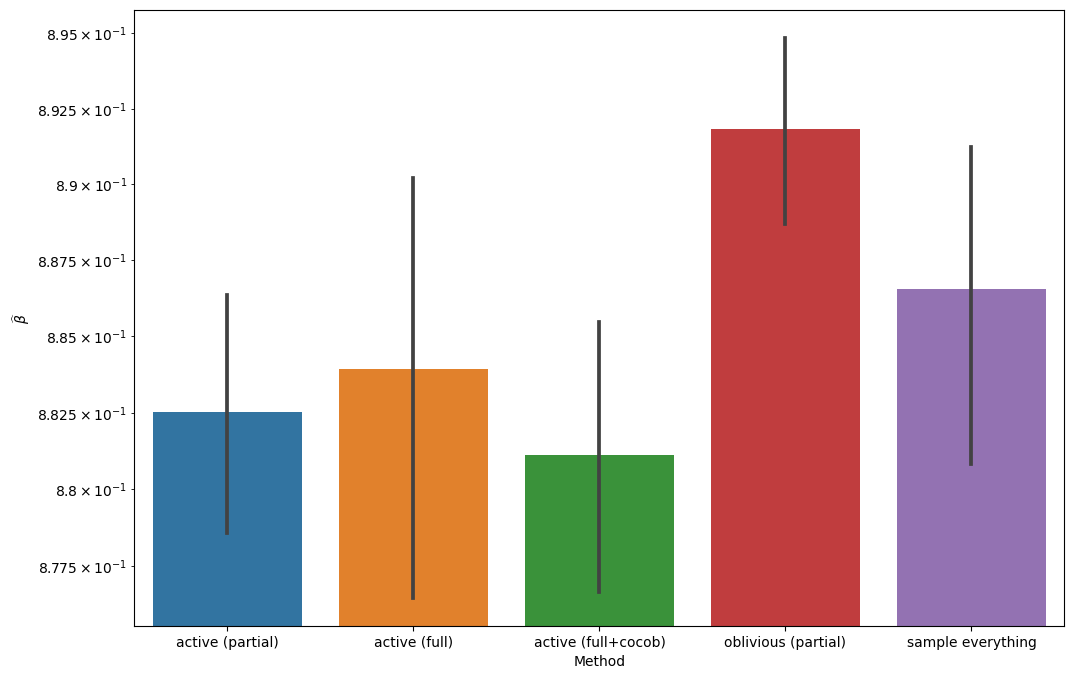

In [17]:
def visualize_beta_hat(beta_hat_data, beta_hat_df):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    records = []
    for names, _, sumlses, betases in beta_hat_data:
        for name, sumls, betas in zip(names, sumlses, betases):
            for labels, beta in zip(sumls, betas):
                records.append({'Method': name, 'Labels': labels, 'Beta': beta})
    plt.figure(figsize=(12,8))

    sns.barplot(data=beta_hat_df[beta_hat_df['Method'] != 'active (shifted)'],
                x='Method', y='$\\widehat{\\beta}$')
    plt.yscale('log')
    # df = pd.DataFrame.from_records(records)
    # print(df)
    # sns.lineplot(data=df, x='Labels', y='Beta', hue='Method')
visualize_beta_hat(beta_hat_data, beta_hat_df)

## COCO MS

COCOMS dataset is a multilabel classification dataset. Hence, examples consist of an image $x \in \mathcal{X}$ that is paired with a _vector_ of labels $\mathbf{y} \in 2^\mathcal{Y}$.

Our goal is is still to form a label set $S$, but now we are interested in computing the inverse of the recall as our loss:

$$ L(\mathbf{y}, S) := L_y \mathbf{1}_{\left\{y \not\in S\right\}},$$

where $L_y \in \mathbb{R}^+$ denotes a user chosen penalty weight specifically for class $y$.

We can use a probabilistic classifier $\mathbf{p}: \mathcal{X} \mapsto \Delta^{|\mathcal{Y}|}$ to produce a probability distribution $\mathbf{p}(x)$ for each image $x$. Then, we can define the corresponding label set as follows:
$$S(x) := \left\{y \in \mathcal{Y}: \mathbf{p}(x)_y \geq \beta \right\},$$
where $\beta \in [0, 1]$ is the cutoff threshold for which labels to include in the label set.

We directly work with $\mathbf{p}(x)$ generated using a ResNet512 classifier trained on Imagenet.

In [ ]:
coco_data_dir = 'data/coco'
coco_scores, coco_labels = load_data(coco_data_dir)
coco_scores.shape, coco_labels.shape

In [ ]:
class NegRecall(object):
    def __init__(self):
        super().__init__()
        
    def __call__(self, PXY, betas, batch=None):
        import numpy as np
        (P, _), Y = PXY
        if batch:
            recall = np.sum((betas <= P).astype(bool) & Y.astype(bool), axis=1) / np.sum(Y, axis=1)
        else:
            recall = np.sum((betas <= P).astype(bool) & Y.astype(bool)) / np.sum(Y)
        return 1 - recall

    def sample(self):
        import torch
        
        p = torch.rand(1)
        y = torch.bernoulli(p)
        return p, y

In [ ]:
def plot_coco_true_rho():
    import matplotlib.pyplot as plt
    import numpy as np
    
    rho = NegRecall()
    betas = np.power(10, -1 * np.arange(1, 2.5, .01))
    
    risks = [np.mean(rho(((coco_scores, None), coco_labels), beta)) for beta in betas]
    fig, ax = plt.figure(), plt.gca()
    ax.plot(betas, risks), ax.set_xlabel('$\\beta$'), ax.set_ylabel('True neg. recall: $\\mathbb{E}[\\rho(X, Y, \\beta)]$')
    ax.set_xscale('log')
    ax.set_title('COCO-MS')
plot_coco_true_rho()

## Simulations

In [ ]:
def ideal_q_preds(scores, labels):
    import sklearn.linear_model
    from sklearn.linear_model import LogisticRegression as LR
    import torch
    scores, labels = torch.Tensor(scores), torch.Tensor(labels)
    betas = torch.arange(0.1, 0.9, 0.2)
    margins = torch.arange(0.1, 0.9, 0.2)
    X = torch.cat([featurize(scores, torch.ones(1000), beta) for beta in betas]).numpy()
    tot_labels = torch.cat([labels for _ in range(betas)])
        
    model = LR(penalty=None, multi_class='multinomial')
    model.fit(X, tot_labels)
    
    probe_data = torch.cat([make_probe_data(beta, torch.ones(1000), margin, featurize) for beta in betas for margin in margins])
    q_vals = model.predict(probe_data).reshape(-1, len(margins))
        
    fig, ax = plt.figure(), plt.gca()
    for i in range(0, len(betas), 1):
        beta, q_val = betas[i], q_vals[i]
        max_margin = 1 - beta
        mask = margins <= max_margin
        ax.plot(margins[mask], q_val[mask], label=f"$\\beta={beta:.1f}$")
    ax.set_xlabel('Margin'), ax.set_ylabel('$q(x)')
    ax.legend()
ideal_q_preds(scores, labels)